In [1]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np
import json
import re
import os

In [2]:
path = "txts"

In [3]:
for dirpath, dirnames, filenames in os.walk(path):
    fnames = [f for f in filenames if f.endswith(".txt")]
print(f"Number of files: {len(fnames)}")

Number of files: 1144


### Remove JSTOR copy:

In [4]:
for f in fnames:
    with open(os.path.join(path, f), "r") as infile:
        pgs = infile.read().split("<newpage>")
    first_pg = pgs[0]
    if re.search("jstor", first_pg, re.I | re.MULTILINE):
        # lookahead to American Sociological Association, which precedes JSTOR terms. Remove terms and everything after
       edit = re.sub("(?=Stable URL).*", "", first_pg, flags=re.I | re.DOTALL | re.MULTILINE)
    pgs = [edit] + pgs[1:]
    # Overwrite the file
    with open(os.path.join(path, f), "w") as outfile:
        outfile.write("<newpage>".join(pgs))

## Average article length in pages:

Mean: 18.262237762237763 | Std: 6.434264746230761 | Max: 46 | Min: 2


(array([ 43.,  82., 237., 306., 275., 142.,  35.,  16.,   4.,   4.]),
 array([ 2. ,  6.4, 10.8, 15.2, 19.6, 24. , 28.4, 32.8, 37.2, 41.6, 46. ]),
 <BarContainer object of 10 artists>)

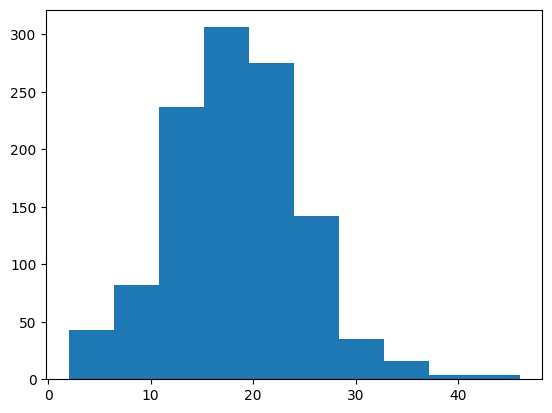

In [5]:
pdf_lens = []
for f in fnames:
    with open(os.path.join(path, f), "r") as infile:
        pgs = infile.read().split("<newpage>")
    pdf_lens.append(len(pgs))
print(f"Mean: {np.mean(pdf_lens)} | Std: {np.std(pdf_lens)} | Max: {np.max(pdf_lens)} | Min: {np.min(pdf_lens)}")
plt.hist(pdf_lens)

## Average page length in tokens:

In [6]:
# go one dir up
llama_dir = os.path.join(os.getcwd(), "..", "codellama", "CodeLlama-7b-Instruct-hf")
tokenizer = AutoTokenizer.from_pretrained(llama_dir, local_files_only=True)

Mean: 1061.2633065288148 | Std: 403.92261827037095 | Max: 3978 | Min: 0


(array([1.497e+03, 3.455e+03, 7.366e+03, 7.151e+03, 1.149e+03, 2.580e+02,
        9.000e+00, 5.000e+00, 0.000e+00, 2.000e+00]),
 array([   0. ,  397.8,  795.6, 1193.4, 1591.2, 1989. , 2386.8, 2784.6,
        3182.4, 3580.2, 3978. ]),
 <BarContainer object of 10 artists>)

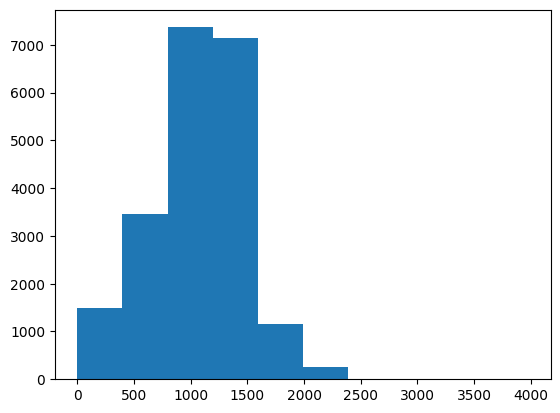

In [7]:
pg_lens = []
for f in fnames:
    with open(os.path.join(path, f), "r") as infile:
        pgs = infile.read().split("<newpage>")
        for pg in pgs:
            pg_lens.append(len(tokenizer.tokenize(pg)))
print(f"Mean: {np.mean(pg_lens)} | Std: {np.std(pg_lens)} | Max: {np.max(pg_lens)} | Min: {np.min(pg_lens)}")
plt.hist(pg_lens)

LLaMA2-Code has a functional context length of 16k tokens.

## Prompt Engineering

In [8]:
p1 = """

### Example of how to code a Sociology of Education article on the basis of 12 selected categories, then store the results in JSON.
# JSON scheme: {"quantitative": bool, "qualitative": bool, "primary/secondary": bool, "tertiary": bool, "inequality": bool, "nonstructural": bool, "culture": bool, "school": bool, "state": bool, "labor": bool, "comparative": bool, "methods": bool}
example_article = '''The "Collective Mind" at
 Work: A Decade in the Life of
 U.S. Sociology of Education
 Sociology of Education
 86(4) 273-279
 © American Sociological Association 20 1 3
 DOI: 10.1177/0038040713503304
 http://soe.sagepub.com
 §SAGE
 Steven Brint

             METHOD
 Between 1999 and 2008, 168 articles appeared in
 Sociology of Education , between 3 and 5 articles
 in each of four issues during the year. (In 2000,
 the journal published a special extra issue, which
 included essays about current thinking about key
 issues in the subdiscipline.) I coded each of the
 articles that met my criteria for inclusion in four
 ways. First, I classified the articles by methodol-
 ogy: either quantitative or qualitative. In a few
 cases, both types of methodology were equally
 prominent. I noted these articles separately. Sec-
 ond, I classified the level of education addressed
 in the article: primary/secondary or tertiary. In
 some cases, articles concerned both primary/sec-
 ondary and tertiary education. In these cases, I
 did not classify the articles. Third, I classified
 the articles into one of eight major topical catego-
 ries: (1) inequality, (2) "nonstructural" sources of
 achievement, (3) culture/ideology, (4) school
 organization/school effects, (5) state/politics, (6)
 labor market/labor market transitions, (7) compar-
 ative/historical analysis, and (8) methods. Finally,
 I classified articles into a more fine-grained topi-
 cal scheme of 22 categories in all. I will concen-
 trate my discussion of content on the distribution
 of articles into the eight major topical categories
 listed above. Therefore, let me elaborate the con-
 ventions that I used in coding articles into these
 categories.
 I classified the articles on the basis of the pri-
 mary emphasis in the article. Where possible, I
 tried to classify under one category only. I classi-
 fied only a handful of articles under more than one
 category, because I could not determine their pri-
 mary emphasis. I made a distinction in coding
 between the major structural bases of inequality
 in American society (i.e., social class, race/ethnic-
 ity, immigration status, and gender) and social
 structures and behaviors that vary within these
 broad strata (such as family structure or student
 work effort). I reserved the category "nonstruc-
 tural sources of achievement" for articles that
 took up these latter sources of variation in educa-
 tional outcomes. Thus, articles about the effects of
 work effort, drinking behavior, or obesity on stu-
 dent achievement were coded into this category,
 but articles about the effects of wealth or immigra-
 tion status on educational attainment were coded
 into the "inequality and schools" category.
 In this coding scheme, "culture/ideology"
 includes articles both on cultural influences on
 the organization of schooling and the influences
 of the organization of schooling on culture. An
 example of the former would be an article on the
 interpersonal strategies used by high-achieving
 students to mask their school achievements in set-
 tings that belittle intellectuality. An example of
 the latter would be an article on the effects of edu-
 cational attainment on attitudes about public
 affairs.
 I will not make strong claims for the accuracy
 of my coding. In some cases, other equally expert
 coders would likely have made different coding
 choices. However, many of the articles were not
 difficult to code, and I believe the measurement
 error due to coding mistakes is relatively minor.'''
# The example article describes a method for qualitative coding, so "quantitative" is False and "qualitative" is True. "primary/secondary" and "tertiary" are both False, because the article does not focus on a specific level of education. "methods" is True, because the article is mainly a review of methods used in the field. "methods" is the article's primary designation, so all 7 remaining categories must be False.
example_json = {"quantitative": False, "qualitative": True, "primary/secondary": False, "tertiary": False, "inequality": False, "nonstructural": False, "culture": False, "school": False, "state": False, "labor": False, "comparative": False, "methods": True}
 
### Code a new article using the same method.
# JSON scheme: {"quantitative": bool, "qualitative": bool, "primary/secondary": bool, "tertiary": bool, "inequality": bool, "nonstructural": bool, "culture": bool, "school": bool, "state": bool, "labor": bool, "comparative": bool, "methods": bool}  
new_article = '''"""


In [9]:
p2 = """''' 
# Return only JSON with correct categorical codes based on the new article. 
new_json = """

### Average prompt length in tokens:

In [10]:
# runs for a moment
for page_num in range(1, 6):
    print(f"Prompt length with {page_num} page(s):")
    prompt_lens = []
    for f in fnames:
        with open(os.path.join(path, f), "r") as infile:
            pgs = infile.read().split("<newpage>")
        input = '<newpage json = {"quantitative": bool, "qualitative": bool, "primary/secondary": bool, "tertiary": bool, "inequality": bool, "nonstructural": bool, "culture": bool, "school": bool, "state": bool, "labor": bool, "comparative": bool, "methods": bool}>'.join(
            pgs[:page_num])
        prompt = p1 + input + p2
        prompt_lens.append(len(tokenizer.tokenize(prompt)))
    print(f"Mean: {np.mean(prompt_lens)} | Std: {np.std(prompt_lens)} | Max: {np.max(prompt_lens)} | Min: {np.min(prompt_lens)}")

Prompt length with 1 page(s):
Mean: 1444.4064685314686 | Std: 12.076243516044213 | Max: 1484 | Min: 1408
Prompt length with 2 page(s):
Mean: 2578.4965034965035 | Std: 242.69612137492393 | Max: 3108 | Min: 1893
Prompt length with 3 page(s):
Mean: 3837.298951048951 | Std: 439.0425849476348 | Max: 4696 | Min: 1971
Prompt length with 4 page(s):
Mean: 5053.336538461538 | Std: 658.3993459936006 | Max: 6297 | Min: 1971
Prompt length with 5 page(s):
Mean: 6235.617132867133 | Std: 905.2528759946995 | Max: 7924 | Min: 1971


### Correct JSON response length in tokens:

In [11]:
all_false = json.dumps({"quantitative": False, "qualitative": False, "primary/secondary": False, "tertiary": False, "inequality": False, "nonstructural": False, "culture": False, "school": False, "state": False, "labor": False, "comparative": False, "methods": False})
print(f"Length of max expected JSON output in tokens: {len(tokenizer.tokenize(all_false))}")

Length of max expected JSON output in tokens: 74
